# Proposed Workflow ("four users" tweets)

In [1]:
library(dplyr)
library(useful)
library(Seurat)
library(patchwork)
library(cluster)
library(ggplot2)
library(randomNames)
library(tidyverse)
library(data.table)
library(lubridate)
library(ggplot2)
library(stringr)
library(monocle3)
library(reshape2)
library(pairwise)
library(scales)
library(data.table)
library(text2vec)
library(Matrix)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Attaching SeuratObject

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last



A

## Step 1: Pre-processing 
(find the code in "/home/rep/scRNA-seq_clustering_to_Twitter/P1_preprocessing/preprocessing.ipynb"

## Step 2: Create cds object

In [2]:
###########################################
########### Monocle3 cds object ###########
###########################################

####### expression (word-document matrix) ########
sparse_matrix = read.csv("/home/rep/scRNA-seq_clustering_to_Twitter/P1_preprocessing/doc_word_matrix_stemming_four_users.csv") %>% dplyr::select(-X)
names = names(sparse_matrix)
sparse_matrix = t(as.matrix(sparse_matrix))
word_expression = sparse_matrix

####### Doc_metadata #######
doc_metadata = read.csv("/home/rep/scRNA-seq_clustering_to_Twitter/P1_preprocessing/doc_metadata_stemming_four_users.csv")  %>% dplyr::select(-X)

####### Word_metadata #######
word_metadata = data.frame(
  word = names,
  gene_short_name = names
)

######## Change row_col names#######
colnames(word_expression) = rownames(doc_metadata)
rownames(word_metadata) = rownames(word_expression)

######## Create Monocle3 Object ##########
cds = new_cell_data_set(expression_data = word_expression,
                         cell_metadata = doc_metadata,
                         gene_metadata = word_metadata)

######## Pre-process ##########
cds = preprocess_cds(cds, num_dim = 100)
cds = reduce_dimension(cds)

No preprocess_method specified, using preprocess_method = 'PCA'



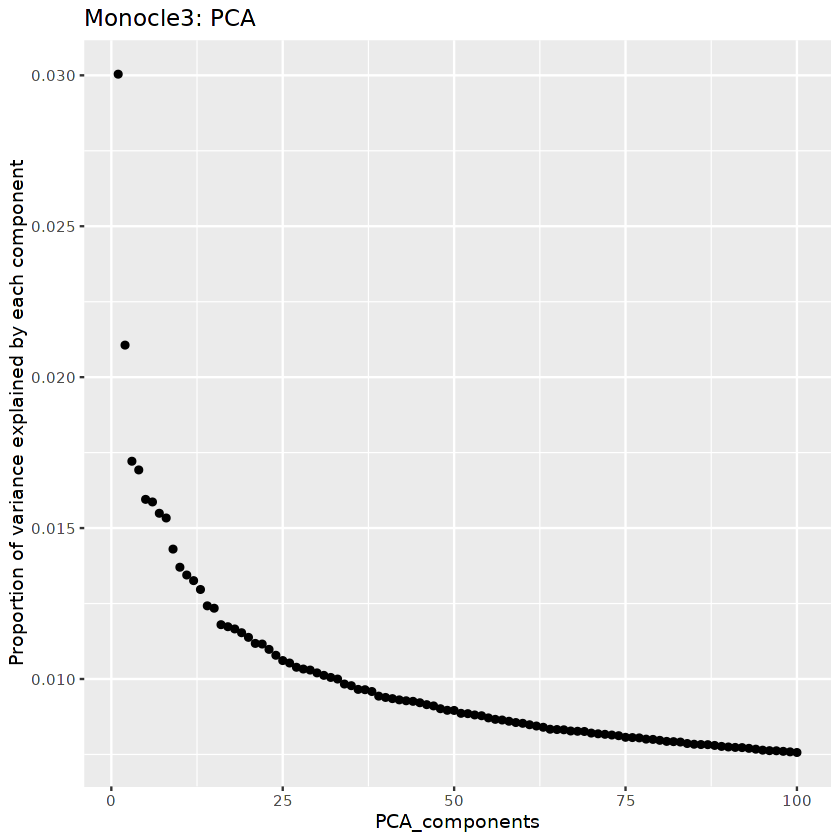

In [3]:
#####################################
############ scree plot #############
#####################################
Monocle3_PCA = cds@int_colData@listData$reducedDims@listData$PCA
nnn = as.data.frame(Monocle3_PCA)
vars_transformed <- apply(nnn, 2, var)
Monocle3_PCA = vars_transformed/sum(vars_transformed)
Monocle3_PCA = as.numeric(Monocle3_PCA)

PCA <- data.frame(
  PCA_components = 1:100,
  Monocle3 = Monocle3_PCA
)

PCA %>% ggplot(aes(x = PCA_components, y = Monocle3)) + geom_point() +
  ylab("Proportion of variance explained by each component") +
  ggtitle("Monocle3: PCA")

# ggsave("PW_plots/scree_monocle3PW_jobs_PCA.png",  width = 15, height = 15, units = "cm")

## Step 3: UMAP Plot (check tiny surrounding clusters)

In [98]:
##########################
###### UMAP plot #########
##########################
cds = preprocess_cds(cds, num_dim = 25)
cds = reduce_dimension(cds)
p1 = plot_cells(cds)
ggsave("PW_plots/UMAP_monocle3PW_four_raw_UMAP.png", p1, width = 15, height = 15, units = "cm")
p2 = plot_cells(cds, color_cells_by="screen_name", group_label_size = 8, label_groups_by_cluster = FALSE)
ggsave("PW_plots/UMAP_monocle3PW_four_raw_true_UMAP.png", p2, width = 15, height = 15, units = "cm")

No preprocess_method specified, using preprocess_method = 'PCA'

No trajectory to plot. Has learn_graph() been called yet?

cluster not found in colData(cds), cells will not be colored

cluster_cells() has not been called yet, can't color cells by cluster

No trajectory to plot. Has learn_graph() been called yet?



In [100]:
###### Study the content of the small communities
# selected_tweets_idx = choose_cells(cds, return_list = TRUE)
# selected_tweets_info = doc_metadata %>% mutate(row_num =row_number()) %>% filter(row_num %in% as.numeric(selected_tweets_idx))

## Step 4: utilize HDBSCAN to seperate the main cluster and the tiny clusters

## Step 5: clustering (focus on the main cluster)

### Part 1: decide tuning parameters

#### (1) Silhouette Analysis

In [135]:
##########################################
########### Silhouette Analysis ##########
##########################################

########### distance matrix ############

reduced_dim_res = reducedDims(main)[["UMAP"]]
distance_matrix = dist(reduced_dim_res, diag = T, upper = T)

Monocle3_results = data.frame(1:dim(main)[2])
num_cluster = vector()
avg_widths = vector()

k_range = c(5:20,30,40,50,60,70,80,90,100,110,120,140, 150,200,300)


for (i in 1:length(k_range)){
  num = as.integer(k_range[i])
  main = cluster_cells(main,  k = num, random_seed = 44)
  x = main@clusters@listData$UMAP$cluster_result$optim_res$membership
  
  #Store results
  num_cluster[i] = as.integer(length(unique(x))) # count the number of clusters
  nn = data.frame(as.numeric(x))
  Monocle3_results = cbind(Monocle3_results, nn)
  
  # Silhouette Analysis
  si = silhouette(x, distance_matrix)
  ssi = summary(si)
  avg_widths[i] = ssi$avg.width
}

summary_sil  = data.frame(k_range, avg_widths, num_cluster)
names(summary_sil) = c("k_range", "avg_widths", "num_cluster")
# write.csv(summary_sil, "PW_files/monocle3PW_four_silhouette.csv")

names(Monocle3_results) = c('idx', k_range)
# write.csv(Monocle3_results, "PW_files/four_estimated_monocle3PW_HDSCAN_stemming.csv")

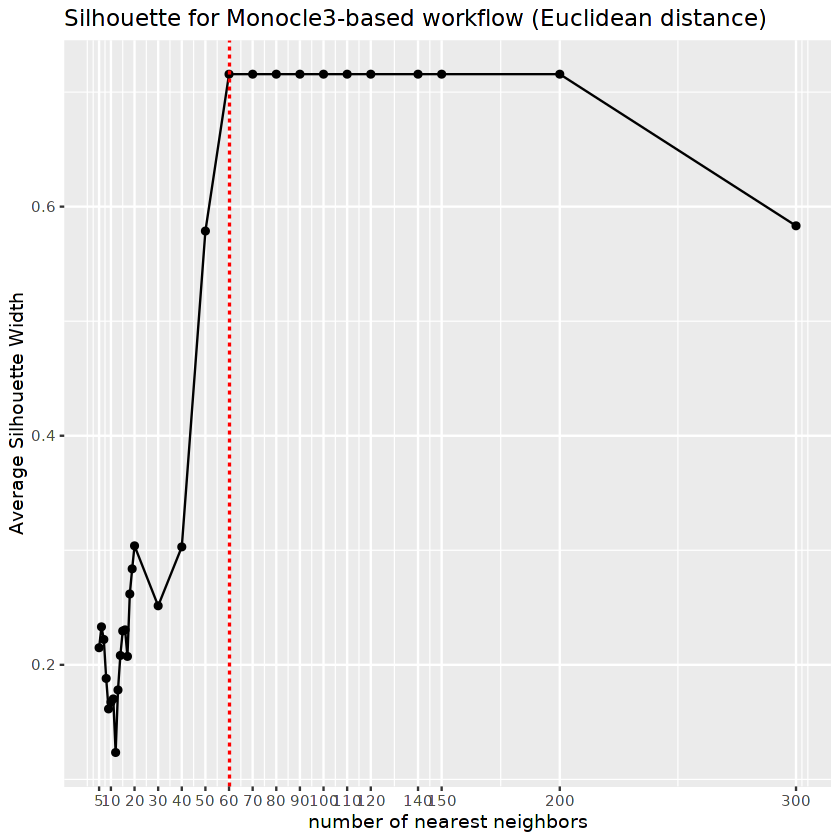

In [10]:
ggplot(data=summary_sil, aes(x=k_range, y=avg_widths)) +
  geom_line()+
  geom_point() + scale_x_continuous(name="number of nearest neighbors", breaks = c(5,10,20,30,40,50,60,70,80,90,100,110,120,140,150,200,300)) +
  scale_y_continuous(name="Average Silhouette Width") + ggtitle("Silhouette for Monocle3-based workflow (Euclidean distance)") +
  geom_vline(xintercept = k_range[which.max(avg_widths)], linetype="dashed", 
                color = "red", size=0.7) 
ggsave("PW_plots/silhouette_euclidean_monocle3PW_four_neighbor.png",  width = 20, height = 15, units = "cm")

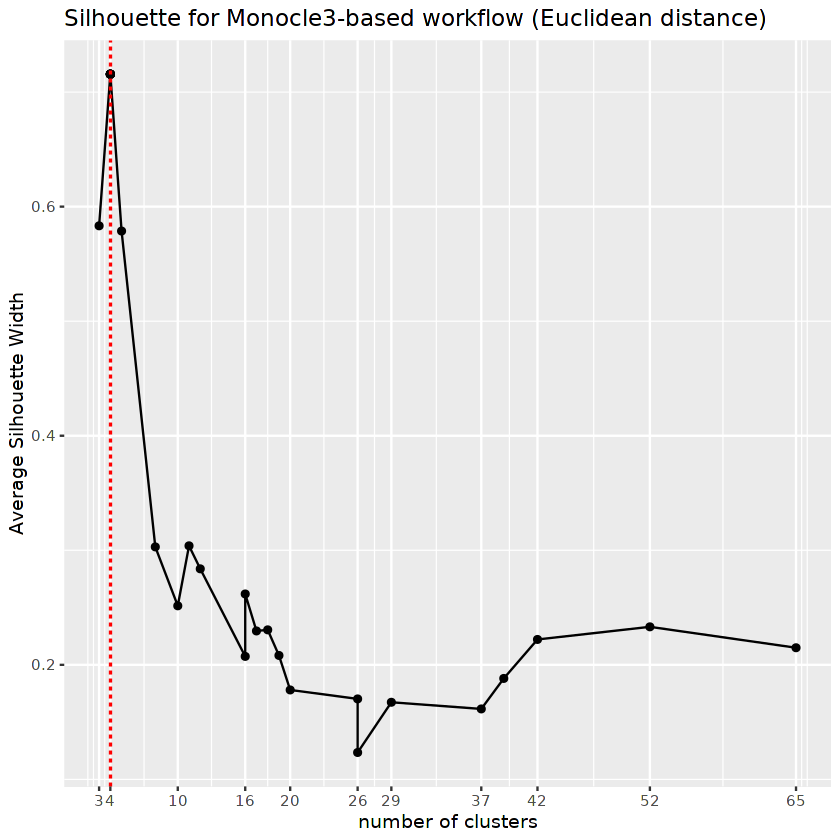

In [13]:
ggplot(data=summary_sil, aes(x=num_cluster, y=avg_widths)) +
  geom_line()+
  geom_point() + scale_x_continuous(name="number of clusters", breaks = c(3,4,10,16,20,26,29,37,42,52,65)) +
  scale_y_continuous(name="Average Silhouette Width") + ggtitle("Silhouette for Monocle3-based workflow (Euclidean distance)") +
  geom_vline(xintercept = num_cluster[which.max(avg_widths)], linetype="dashed", 
                color = "red", size=0.7) 

# ggsave("PW_plots/silhouette_euclidean_monocle3PW_four_cluster.png",  width = 20, height = 15, units = "cm")

#### (2) coherence

In [140]:
###### expression (word-document matrix[tf_idf]) ######
# "doc_word_matrix_stemming_four_DBSCAN_tfidf.csv" is obtained from PW_tfidf.ipynb
tfidf = read.csv("PW_files/doc_word_matrix_stemming_four_DBSCAN_tfidf.csv") %>% dplyr::select(-X)
tfidf_sparse_matrix = as.matrix(tfidf)

####### Doc_metadata #######
df_compare = as.data.frame(colData(main))
df_compare = df_compare %>% mutate(idx = 1:nrow(df_compare))

# Create word co-occurence
dtm_four <- Matrix(tfidf_sparse_matrix, sparse = TRUE) 
tcm_four = crossprod(sign(dtm_four))
N = dim(tfidf_sparse_matrix)[1]

In [141]:
# Calculate coherence score for different number of nearest neighbors
avg_coherence = vector()

for (i in 1:length(k_range)){
  # Clustering results
  x = Monocle3_results[[i+1]]
  
  # Get tw
  df_compare = df_compare %>% mutate(Monocle3_results = x)
  summary_table = data.frame(1:ncol(tfidf_sparse_matrix))
   
  for(j in 1:length(unique(df_compare$Monocle3_results))){
  
  cluster_j = tfidf_sparse_matrix[as.numeric(df_compare %>% filter(Monocle3_results == j) %>% .$idx),]
  
  words = colSums(cluster_j)/nrow(cluster_j)
  sort_by_freq = sort(words, decreasing = TRUE)
  
  summary_table = cbind(summary_table, data.frame(names(sort_by_freq)))
  }
    
  summary_table = summary_table[,-1]
  names(summary_table) = as.character(1:length(unique(df_compare$Monocle3_results)))
    
  tw_four = as.matrix(summary_table[1:20,])
    
  # Compute coherence
  res = coherence(tw_four, tcm_four, n_doc_tcm = length(x), metrics = "mean_npmi_cosim2")
  avg_coherence[i] = mean(as.data.frame(res)[,1])
}

In [142]:
summary_coh = data.frame(k_range, avg_coherence, num_cluster)
# write.csv(summary_coh, "PW_files/Monocle3PW_coherence_summary_four.csv")

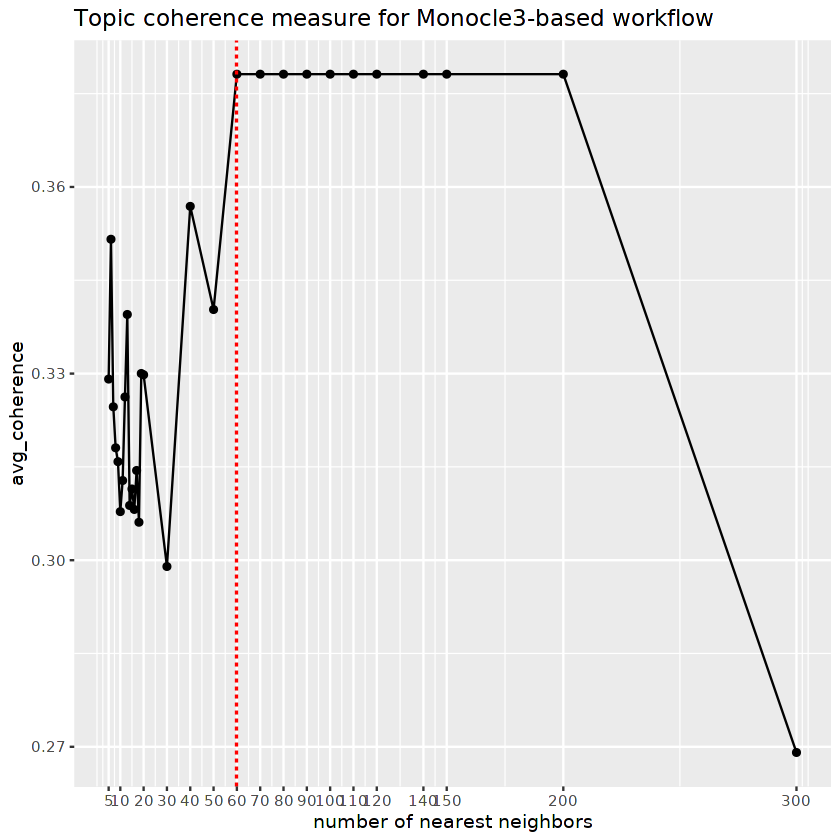

In [15]:
ggplot(data=summary_coh, aes(x=k_range, y=avg_coherence)) +
  geom_line()+
  geom_point() + scale_x_continuous(name="number of nearest neighbors", breaks = c(5,10,20,30,40,50,60,70,80,90,100,110,120,140,150,200,300)) +
  scale_y_continuous(name="avg_coherence") + ggtitle("Topic coherence measure for Monocle3-based workflow") +
  geom_vline(xintercept = k_range[which.max(avg_coherence)], linetype="dashed", 
                color = "red", size=0.7) 

ggsave("PW_plots/coherence_monocle3PW_four_neighbor_tfidf.png",  width = 20, height = 15, units = "cm")

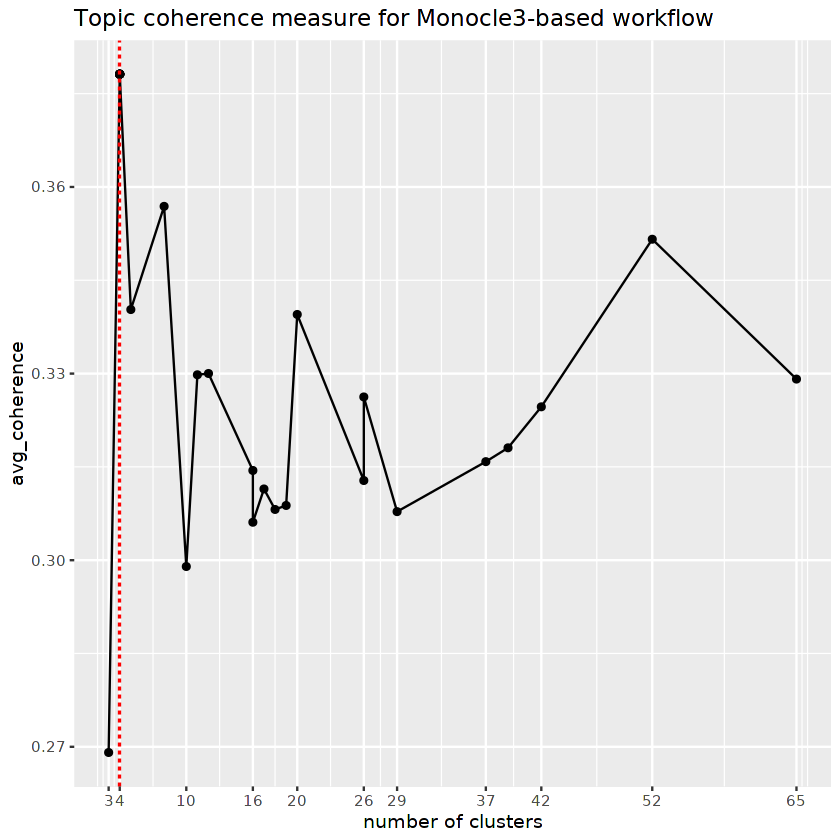

In [16]:
ggplot(data=summary_coh, aes(x=num_cluster, y=avg_coherence)) +
  geom_line()+
  geom_point() + scale_x_continuous(name="number of clusters", breaks = c(3,4,10,16,20,26,29,37,42,52,65)) +
  scale_y_continuous(name="avg_coherence") + ggtitle("Topic coherence measure for Monocle3-based workflow") +
  geom_vline(xintercept = num_cluster[which.max(avg_coherence)], linetype="dashed", 
                color = "red", size=0.7) 

ggsave("PW_plots/coherence_monocle3PW_four_cluster_tfidf.png",  width = 20, height = 15, units = "cm")

### Part 2: Monocle3 Clustering

In [146]:
#################################################################
##################### Monocle3 Clustering #######################
#################################################################
k = k_range[which.max(avg_coherence)]
main = cluster_cells(main, k, reduction_method = "UMAP", random_seed = 44)

### UMAP ###
# (1) Clustering results
p1 = plot_cells(main, group_label_size = 8)
ggsave("PW_plots/UMAP_monocle3PW_four_afterestimate_UMAP.png", p1, width = 15, height = 15, units = "cm")

# (2) True labels
p2 = plot_cells(main, color_cells_by="screen_name", group_label_size = 8, label_groups_by_cluster = FALSE)
ggsave("PW_plots/UMAP_monocle3PW_four_aftertrue_UMAP.png", p2, width = 15, height = 15, units = "cm")

No trajectory to plot. Has learn_graph() been called yet?

No trajectory to plot. Has learn_graph() been called yet?



## Step 6: Subsequent analysis of topics

#### (1) Feature word selection

In [172]:
# Contingency table
sub_Contingency = contingency_table(main, Monocle3_results, k = summary_coh$k_range[which.max(summary_coh$avg_coherence)])
sub_Contingency

# print top ten words according to tfidf
top = top_words(main, Monocle3_results, k = summary_coh$k_range[which.max(summary_coh$avg_coherence)], criteria = "tfidf", tfidf_matrix = tfidf_sparse_matrix)
head(top,10)

# Select feature words
features = feature_words(top,top_n = 10,len = 3)
features

clustering_results,PPFA,UMichFootball,breakingweather,vegancook101
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20,65,2,3102
2,2993,112,12,21
3,29,69,2941,12
4,79,2550,109,21


,1,2,3,4
,<chr>,<chr>,<chr>,<chr>
1,vegan,health,storm,goblu
2,recip,care,across,michigan
3,tofu,ppfa,week,umichfootbal
4,chocol,plan,tropic,touchdown
5,easi,parenthood,wind,problu
6,made,abort,rain,game
7,bean,women,state,big
8,salad,peopl,thunderstorm,day
9,potato,thank,unit,go


[1] "number of features:39"


[1] "vegan"        "recip"        "tofu"         "chocol"       "easi"        
 [6] "made"         "bean"         "salad"        "potato"       "chickpea"    
[11] "health"       "care"         "ppfa"         "plan"         "parenthood"  
[16] "abort"        "women"        "peopl"        "thank"        "get"         
[21] "storm"        "across"       "week"         "tropic"       "wind"        
[26] "rain"         "state"        "thunderstorm" "unit"         "weekend"     
[31] "goblu"        "michigan"     "umichfootbal" "touchdown"    "problu"      
[36] "game"         "big"          "day"          "play"

#### (2) Identification of Topics (run self-defined functions first)

In [173]:
##################################################################
######################### (1) Dot plot ###########################
##################################################################
##################################################################
# Source code from: https://github.com/cole-trapnell-lab/monocle3
##################################################################

# dot plot
p1 = plot_words_by_group_dot(main, features, tf_idf_DT_mtx = tfidf_sparse_matrix, color_measure = "avg_tf_idf")
# ggsave("PW_plots/monocle3PW__dotfour.png", p1, width = 20, height = 30, units = "cm")

`summarise()` has grouped output by 'Group'. You can override using the `.groups` argument.



In [175]:
#####################################################################
########################## (2) Heatmap ##############################
#####################################################################
#####################################################################
# Source code from: https://github.com/satijalab/seurat/tree/master/R
#####################################################################

# Marker words by each cluster
doc_word_matrix = as.data.frame(as.matrix(t(exprs(main)))[,colnames(tfidf_sparse_matrix)])
rownames(doc_word_matrix) = NULL

# dot plot
p2 = plot_words_by_group_heatmap(main, freq_DT_mtx = as.matrix(doc_word_matrix), markers = features)
# ggsave("PW_plots/monocle3PW_four_heat.png", p2, width = 20, height = 20, units = "cm")

## self-defined functions

In [157]:
# generate contingency table
# Input: (1) cds: Monocle3 object
#        (2) clustering_results: clustering results (the first column is idx)
#        (3) k: number of nearest neighbors
# Output: (1) contingency table 
contingency_table = function(cds, clustering_results, k){
    k = as.character(k)
    df_compare = as.data.frame(colData(cds))
    df_compare = df_compare %>% mutate(idx = 1:nrow(df_compare)) 
    clustering_results_selected = as.numeric(clustering_results[,k])
    df_compare = df_compare %>% mutate(clustering_results = clustering_results_selected)
    organize = df_compare %>% dplyr::count(screen_name, clustering_results)  
    contingency_table = spread(organize, screen_name, n, fill = 0, convert = FALSE)
    return(contingency_table)
}

In [171]:
# sort words for each cluster
# Input: (1) cds: Monocle3 object
#        (2) clustering_results: clustering results (the first column is idx)
#        (3) k: number of nearest neighbors
#        (4) criteria: the cirteria to decide the top words. Either "frequency" or "tfidf". 
#        (5) tfidf_matrix: a DT_matrix where the entries are tfidf scores
# Output: (1) Top words for each cluster, sorted by some criteria in descending or order
top_words = function(cds, clustering_results, k, criteria = c("frequency", "tfidf"), tfidf_matrix = NULL){
    df_compare = as.data.frame(colData(cds))
    df_compare = df_compare %>% mutate(idx = 1:nrow(df_compare)) 
    clustering_results_selected = as.numeric(clustering_results[,as.character(k)])
    df_compare = df_compare %>% mutate(clustering_results = clustering_results_selected)
    
    if(criteria == "frequency"){
        DT_matrix = t(as.matrix(exprs(cds)))
    } else{
        DT_matrix = tfidf_matrix
    }
    
    
    summary_table = data.frame(1:ncol(DT_matrix))
    
    for(j in 1:length(unique(df_compare$clustering_results))){
        
        cluster_j = DT_matrix[as.numeric(df_compare %>% filter(clustering_results == j) %>% .$idx),]
        words = colSums(cluster_j)/nrow(cluster_j)
        sort_by_freq = sort(words, decreasing = TRUE)
        summary_table = cbind(summary_table, data.frame(names(sort_by_freq)))
  }
    summary_table = summary_table[,-1]
    names(summary_table) = as.character(1:length(unique(df_compare$clustering_results)))
    
    return(summary_table)
}

In [151]:
# decide the feature words
# Input: (1) sorted_words: the object returned from top_words
#        (2) top_n: select top_n words to construct the list of features
#        (3) len: minimum length of words for the words in the list of features
# Output: (1) a vector of feature words (unique)
feature_words = function(sorted_words,top_n = 10,len = 3){
    marker = unique(as.vector(as.matrix(sorted_words)[1:10,]))
    Final_marker = vector()
    
    for(i in 1:length(marker)){
        # exclude the words with < 3 letters
        if(nchar(marker[i])>=len){
            Final_marker = c(Final_marker, marker[i])
        }
    }
    
    print(paste0("number of features:", length(Final_marker)))
    return(Final_marker)
}

In [152]:
##################################################################
######################### (1) Dot plot ###########################
##################################################################
##################################################################
# Source code from: https://github.com/cole-trapnell-lab/monocle3
##################################################################
# Define function
plot_words_by_group_dot = function(
  cds,
  markers,
  tf_idf_DT_mtx = NULL, # required if color_measure is "avg_tf_idf"
  color_measure = c("avg_tf_idf", "pseudo_tf_idf", "mean"),
  group_cells_by="cluster",
  ordering_type = 'cluster_row_col',
  flip_percentage_mean = FALSE,
  axis_order = 'group_marker'
){
  word_ids = as.data.frame(fData(cds)) %>%
    tibble::rownames_to_column() %>% 
    filter(rowname %in% markers) %>%
    pull(rowname)
  
  if(color_measure == "avg_tf_idf"){
      exprs_mat = reshape2::melt(tf_idf_DT_mtx[,word_ids])
  }
  if(color_measure == "pseudo_tf_idf"){
      exprs_mat = reshape2::melt(t(as.matrix(exprs(cds)[word_ids, ])))
  }
  
  colnames(exprs_mat) = c('Cell', 'Gene', 'Expression')
  exprs_mat$Gene = as.character(exprs_mat$Gene)
  
  if(group_cells_by == "cluster"){
    exprs_mat$Group = cds@clusters@listData$UMAP$cluster_result$optim_res$membership
  } else {
    exprs_mat$Group =  colData(cds)$category
  }
  
  exprs_mat = exprs_mat %>% dplyr::filter(is.na(Group) == FALSE)
  
  ExpVal = exprs_mat %>% dplyr::group_by(Group, Gene) %>%
    dplyr::summarize(mean = mean(Expression),
                     percentage = sum(Expression > 0) /
                       length(Expression))
  ExpVal = ExpVal %>% group_by(Group) %>% mutate(avg_mean = mean(mean), avg_perc = mean(percentage))
  
  if (color_measure == "tf_idf"){
    d = as.data.frame(as.matrix(t(exprs(cds))))
    d = d %>% mutate(temp_help= as.numeric(cds@clusters@listData$UMAP$cluster_result$optim_res$membership))
    d = aggregate(. ~ temp_help, data=d, FUN=sum)
    rownames = d$temp_help
    d = d %>% select(-temp_help)
    rownames(d) = rownames
    
    # calculate class-based TF-IDF
    tf <- d/rowSums(d)
    idf <- log(nrow(d)/(1 + colSums(d > 0))) + 1
    tfidf <- d
    for(word in names(idf)){
      tfidf[,word] <- tf[,word] * idf[word]
    }
    
    tfidf_mat = reshape2::melt(as.matrix(tfidf[,word_ids]))
    colnames(tfidf_mat) = c('Group', 'Gene', 'tf_idf_Expression')
    tfidf_mat$Gene = as.character(tfidf_mat$Gene)
    tfidf_mat = tfidf_mat %>% arrange(Group) 
    
    ExpVal$mean = tfidf_mat$tf_idf_Expression
  }
  
  if(flip_percentage_mean == FALSE){
    major_axis = 1
    minor_axis = 2
  } else if (flip_percentage_mean == TRUE){
    major_axis = 2
    minor_axis = 1
  }
  
  res = reshape2::dcast(ExpVal[, 1:4], Group ~ Gene,
                        value.var = colnames(ExpVal)[2 + major_axis])
  group_id = res[, 1]
  res = res[, -1]
  row.names(res) = group_id
  
  if(ordering_type == 'cluster_row_col') {
    row_dist = stats::as.dist((1 - stats::cor(t(res)))/2)
    row_dist[is.na(row_dist)] = 1
    
    col_dist = stats::as.dist((1 - stats::cor(res))/2)
    col_dist[is.na(col_dist)] = 1
    
    ph = pheatmap::pheatmap(res,
                            useRaster = T,
                            cluster_cols=TRUE,
                            cluster_rows=TRUE,
                            show_rownames=F,
                            show_colnames=F,
                            clustering_distance_cols=col_dist,
                            clustering_distance_rows=row_dist,
                            clustering_method = 'ward.D2',
                            silent=TRUE,
                            filename=NA)
    
    ExpVal$Gene = factor(ExpVal$Gene,
                         levels = colnames(res)[ph$tree_col$order])
    ExpVal$Group = factor(ExpVal$Group,
                          levels = row.names(res)[ph$tree_row$order])
    
  } else if(ordering_type == 'maximal_on_diag'){
    
    order_mat = t(apply(res, major_axis, order))
    max_ind_vec = c()
    for(i in 1:nrow(order_mat)) {
      tmp = max(which(!(order_mat[i, ] %in% max_ind_vec)))
      max_ind_vec = c(max_ind_vec, order_mat[i, tmp])
    }
    max_ind_vec = max_ind_vec[!is.na(max_ind_vec)]
    
    if(major_axis == 1){
      max_ind_vec = c(max_ind_vec, setdiff(1:length(markers), max_ind_vec))
      ExpVal$Gene = factor(ExpVal$Gene ,
                           levels = dimnames(res)[[2]][max_ind_vec])
    }
    else{
      max_ind_vec = c(max_ind_vec, setdiff(1:length(unique(exprs_mat$Group)),
                                           max_ind_vec))
      ExpVal$Group = factor(ExpVal$Group,
                            levels = dimnames(res)[[1]][max_ind_vec])
    }
  } else if(ordering_type == 'none'){
    ExpVal$Gene = factor(ExpVal$Gene, levels = markers)
  }
  
  if(flip_percentage_mean){
    g = ggplot(ExpVal, aes(y = Gene,  x = Group)) +
      geom_point(aes(colour = percentage,  size = mean)) +
      viridis::scale_color_viridis(name = 'percentage') +
      scale_size(name = color_measure, range = c(0, 10))
  } else {
    g = ggplot(ExpVal, aes(y = Gene,  x = Group)) +
      geom_point(aes(colour = mean,  size = percentage)) +
      viridis::scale_color_viridis(name = color_measure) +
      scale_size(name = 'percentage', range = c(1, 8))
  }
  
  if (group_cells_by == "cluster"){
    g = g + xlab("Cluster")
  } else if (group_cells_by == "partition") {
    g = g + xlab("Partition")
  } else{
    g = g + xlab(group_cells_by)
  }
  
  monocle_theme_opts = function()
  {
    theme(strip.background = element_rect(colour = 'white', fill = 'white')) +
      theme(panel.border = element_blank()) +
      theme(axis.line.x = element_line(size=0.25, color="black")) +
      theme(axis.line.y = element_line(size=0.25, color="black")) +
      theme(panel.grid.minor.x = element_blank(),
            panel.grid.minor.y = element_blank()) +
      theme(panel.grid.major.x = element_blank(),
            panel.grid.major.y = element_blank()) +
      theme(panel.background = element_rect(fill='white')) +
      theme(legend.key=element_blank())
  }
  
  g = g + ylab("Word") + monocle_theme_opts() +
    theme(axis.text.x = element_text(angle = 30, hjust = 1))
  if(axis_order == 'marker_group') {
    g = g + coord_flip()
  }
  
  g
}

In [153]:
#####################################################################
########################## (2) Heatmap ##############################
#####################################################################
#####################################################################
# Source code from: https://github.com/satijalab/seurat/tree/master/R
#####################################################################
# Run supplementary functions for heatmap first
# Define function
# Define function
plot_words_by_group_heatmap = function(
  cds,
  freq_DT_mtx,
  markers,
  cells = NULL,
  group.by = 'ident',
  group.bar = TRUE,
  group.colors = NULL,
  disp.min = -2.5,
  disp.max = NULL,
  slot = 'counts',
  label = TRUE,
  size = 5.5,
  hjust = 0,
  angle = 45,
  raster = TRUE,
  draw.lines = TRUE,
  lines.width = NULL,
  group.bar.height = 0.02,
  combine = TRUE
){
  object = cds
  colnames(object) = 1:ncol(object)
  sparse_matrix = as.data.frame(freq_DT_mtx)
  cells <- cells %||% colnames(x = object)
  if (is.numeric(x = cells)) {
    cells <- colnames(x = object)[cells]
  }
  
  markers <- markers %||% rownames(object)
  markers <- rev(x = unique(x = markers))
  disp.max <- disp.max %||% ifelse(
    test = slot == 'scale.data',
    yes = 2.5,
    no = 6
  )
  
  data = sparse_matrix %>% select(all_of(markers))
  group.by <- group.by %||% 'ident'
  groups.use <- data.frame(idnt = object@clusters@listData$UMAP$cluster_result$optim_res$membership)
 
  plots <- vector(mode = 'list', length = ncol(x = groups.use))
  for (i in 1:ncol(x = groups.use)) {

    data.group <- data
    group.use <- groups.use[, i, drop = TRUE]
    if (!is.factor(x = group.use)) {
      group.use <- factor(x = group.use)
    }
    names(x = group.use) <- cells
    
    if (draw.lines) {
      # create fake cells to serve as the white lines, fill with NAs
      lines.width <- lines.width %||% ceiling(x = nrow(x = data.group) * 0.0025)
      placeholder.cells <- sapply(
        X = 1:(length(x = levels(x = group.use)) * lines.width),
        FUN = function(x) {
          return(randomNames())
        }
      )
      placeholder.groups <- rep(x = levels(x = group.use), times = lines.width)
      group.levels <- levels(x = group.use)
      names(x = placeholder.groups) <- placeholder.cells
      group.use <- as.vector(x = group.use)
      names(x = group.use) <- cells
      group.use <- factor(x = c(group.use, placeholder.groups), levels = group.levels)
      na.data.group <- matrix(
        data = NA,
        nrow = length(x = placeholder.cells),
        ncol = ncol(x = data.group),
        dimnames = list(placeholder.cells, colnames(x = data.group))
      )
      data.group <- rbind(data.group, na.data.group)
    }

    lgroup <- length(levels(group.use))

    plot <- SingleRasterMap(
      data = data.group,
      raster = raster,
      disp.min = disp.min,
      disp.max = disp.max,
      markers.order = markers,
      cell.order = names(x = sort(x = group.use)),
      group.by = group.use
    )

    if (group.bar) {
      # TODO: Change group.bar to annotation.bar
      default.colors <- c(hue_pal()(length(x = levels(x = group.use))))
      if (!is.null(x = names(x = group.colors))) {
        cols <- unname(obj = group.colors[levels(x = group.use)])
      } else {
        cols <- group.colors[1:length(x = levels(x = group.use))] %||% default.colors
      }
      if (any(is.na(x = cols))) {
        cols[is.na(x = cols)] <- default.colors[is.na(x = cols)]
        cols <- Col2Hex(cols)
        col.dups <- sort(x = unique(x = which(x = duplicated(x = substr(
          x = cols,
          start = 1,
          stop = 7
        )))))
        through <- length(x = default.colors)
        while (length(x = col.dups) > 0) {
          pal.max <- length(x = col.dups) + through
          cols.extra <- hue_pal()(pal.max)[(through + 1):pal.max]
          cols[col.dups] <- cols.extra
          col.dups <- sort(x = unique(x = which(x = duplicated(x = substr(
            x = cols,
            start = 1,
            stop = 7
          )))))
        }
      }
      group.use2 <- sort(x = group.use)
      if (draw.lines) {
        na.group <- randomNames()
        levels(x = group.use2) <- c(levels(x = group.use2), na.group)
        group.use2[placeholder.cells] <- na.group
        cols <- c(cols, "#FFFFFF")
      }
      pbuild <- ggplot_build(plot = plot)
      names(x = cols) <- levels(x = group.use2)
      # scale the height of the bar
      y.range <- diff(x = pbuild$layout$panel_params[[1]]$y.range)
      y.pos <- max(pbuild$layout$panel_params[[1]]$y.range) + y.range * 0.015
      y.max <- y.pos + group.bar.height * y.range
      x.min <- min(pbuild$layout$panel_params[[1]]$x.range) + 0.1
      x.max <- max(pbuild$layout$panel_params[[1]]$x.range) - 0.1
      plot <- plot +
        annotation_raster(
          raster = t(x = cols[group.use2]),
          xmin = x.min,
          xmax = x.max,
          ymin = y.pos,
          ymax = y.max
        ) +
        coord_cartesian(ylim = c(0, y.max), clip = 'off') +
        scale_color_manual(values = cols)
     
      if (label) {
        x.max <- max(pbuild$layout$panel_params[[1]]$x.range)
        # Attempt to pull xdivs from x.major in ggplot2 < 3.3.0; if NULL, pull from the >= 3.3.0 slot
        x.divs <- pbuild$layout$panel_params[[1]]$x.major %||% attr(x = pbuild$layout$panel_params[[1]]$x$get_breaks(), which = "pos")
        x <- data.frame(group = sort(x = group.use), x = x.divs)
        label.x.pos <- tapply(X = x$x, INDEX = x$group, FUN = function(y) {
          if (isTRUE(x = draw.lines)) {
            mean(x = y[-length(x = y)])
          } else {
            mean(x = y)
          }
        })
        label.x.pos <- data.frame(group = names(x = label.x.pos), label.x.pos)
        plot <- plot + geom_text(
          stat = "identity",
          data = label.x.pos,
          aes_string(label = 'group', x = 'label.x.pos'),
          y = y.max + y.max * 0.03 * 0.5,
          angle = angle,
          hjust = hjust,
          size = size
        )
        plot <- suppressMessages(plot + coord_cartesian(
          ylim = c(0, y.max + y.max * 0.002 * max(nchar(x = levels(x = group.use))) * size),
          clip = 'off')
        )
      }
    }
    plot <- plot + theme(line = element_blank())
    plots[[i]] <- plot
  }
  if (combine) {
    plots <- wrap_plots(plots)
  }
  
  return(plots)
}

In [154]:
#####################################################
######## supplementary functions for heatmap ########
#####################################################

# Set a default value if an object is NOT null
#
# @param lhs An object to set if it's NOT null
# @param rhs The value to provide if x is NOT null
#
# @return lhs if lhs is null, else rhs
#
# @author Hadley Wickham
# @references https://adv-r.hadley.nz/functions.html#missing-arguments
#
`%iff%` <- function(lhs, rhs) {
  if (!is.null(x = lhs)) {
    return(rhs)
  } else {
    return(lhs)
  }
}


# A single heatmap from ggplot2 using geom_raster
#
# @param data A matrix or data frame with data to plot
# @param raster switch between geom_raster and geom_tile
# @param cell.order ...
# @param feature.order ...
# @param cols A vector of colors to use
# @param disp.min Minimum display value (all values below are clipped)
# @param disp.max Maximum display value (all values above are clipped)
# @param limits A two-length numeric vector with the limits for colors on the plot
# @param group.by A vector to group cells by, should be one grouping identity per cell
#
#' @importFrom ggplot2 ggplot aes_string geom_raster scale_fill_gradient
#' scale_fill_gradientn theme element_blank labs geom_point guides guide_legend geom_tile
#'
#
SingleRasterMap <- function(
  data,
  raster = TRUE,
  cell.order = NULL,
  markers.order = NULL,
  #colors = PurpleAndYellow(),
  colors = c("#D6E8D9", "#000000"),
  disp.min = -2.5,
  disp.max = 2.5,
  limits = NULL,
  group.by = NULL
) {
  data <- MinMax(data = data, min = disp.min, max = disp.max)
  data <- melt(t(x = data))
  colnames(x = data) <- c('Feature', 'Cell', 'Expression')
  if (!is.null(x = markers.order)) {
    data$Feature <- factor(x = data$Feature, levels = unique(x = markers.order))
  }
  if (!is.null(x = cell.order)) {
    data$Cell <- factor(x = data$Cell, levels = unique(x = cell.order))
  }
  if (!is.null(x = group.by)) {
    data$Identity <- group.by[data$Cell]
  }
  limits <- limits %||% c(min(data$Expression), max(data$Expression))
  if (length(x = limits) != 2 || !is.numeric(x = limits)) {
    stop("limits' must be a two-length numeric vector")
  }
  my_geom <- ifelse(test = raster, yes = geom_raster, no = geom_tile)
  plot <- ggplot(data = data) +
    my_geom(mapping = aes_string(x = 'Cell', y = 'Feature', fill = 'Expression')) +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
    scale_fill_gradientn(limits = limits, colors = colors, na.value = "white") +
    labs(x = NULL, y = NULL, fill = group.by %iff% 'Expression') +
    WhiteBackground() + NoAxes(keep.text = TRUE)
  if (!is.null(x = group.by)) {
    plot <- plot + geom_point(
      mapping = aes_string(x = 'Cell', y = 'Feature', color = 'Identity'),
      alpha = 0
    ) +
      guides(color = guide_legend(override.aes = list(alpha = 1))) + theme(legend.position = "none")
  }
  return(plot)
}